# MDG1 - Eradicate Extreme Poverty And Hunger 

#### In order to begin our analysis let's review how wealth has grown around the years among the different countries. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

import plotly.plotly as py
import plotly 
plotly.tools.set_credentials_file(username='jmattos', api_key='b5w4hhi6KXLdApb07r9s')

import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools

init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

In [6]:
country_metadata = pd.read_csv('data\\GDP_BY_COUNTRY\\Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv')
country_metadata.drop(['IncomeGroup', 'SpecialNotes', 'TableName', 'Unnamed: 5'], axis=1, inplace=True)

# Loading historical GDP by country data from World Bank Data(data.worldbank.org)
historical_gdp_by_country = pd.read_csv('data\\GDP_BY_COUNTRY\\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10515210.csv', header=2)
historical_gdp_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_gdp_by_country = pd.merge(historical_gdp_by_country, country_metadata, how='left', on=['Country Code'])
historical_gdp_by_country = historical_gdp_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='GDP(US$)')

historical_gdp_by_country['GDP(US$)'] = historical_gdp_by_country['GDP(US$)'].apply(lambda x : x/10**9)
historical_gdp_by_country.rename(columns={'GDP(US$)': 'GDP(US$ in Billions)'}, inplace=True)

# Loading historical Population by country data from World Bank(data.worldbank.org)
historical_pop_by_country = pd.read_csv('data\\POP_BY_COUNTRY\\API_SP.POP.TOTL_DS2_en_csv_v2_10515200.csv', header=2)
historical_pop_by_country.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 63'], axis=1, inplace=True)

historical_pop_by_country = pd.merge(historical_pop_by_country, country_metadata, how='left', on=['Country Code'])
historical_pop_by_country = historical_pop_by_country.melt(id_vars=['Country Name', 'Country Code', 'Region'], var_name='Year', value_name='Pop(in millions)')

historical_pop_by_country = historical_pop_by_country[(historical_pop_by_country['Pop(in millions)'] != 'SP.POP.TOTL') & (historical_pop_by_country['Pop(in millions)'] != 'Population, total')]
historical_pop_by_country['Pop(in millions)'].astype(np.float64, copy=False)
historical_pop_by_country['Pop(in millions)'] = historical_pop_by_country['Pop(in millions)'].apply(lambda x : x/10**6)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [3]:
historical_gdp_by_region = historical_gdp_by_country.groupby(by=['Region','Year'], as_index=False).agg({'GDP(US$ in Billions)': 'sum'})
historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['GDP(US$ in Billions)'] > 0]

historical_pop_by_region = historical_pop_by_country.groupby(by=['Region', 'Year'], as_index=False).agg({'Pop(in millions)': 'sum'})
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Pop(in millions)'] > 0]

historical_gdp_per_capita_by_region = historical_gdp_by_region[['Region', 'Year']]
historical_gdp_per_capita_by_region['GDP Per Capita (per US$1.000,00)'] = historical_gdp_by_region['GDP(US$ in Billions)']*(10**3)/historical_pop_by_region['Pop(in millions)']

historical_gdp_by_region = historical_gdp_by_region[historical_gdp_by_region['Year'] > '1980']
historical_pop_by_region = historical_pop_by_region[historical_pop_by_region['Year'] > '1980']
historical_gdp_per_capita_by_region = historical_gdp_per_capita_by_region[historical_gdp_per_capita_by_region['Year'] > '1980']


## Brief Economical Evaluation - GDP, Population and GDP per capita

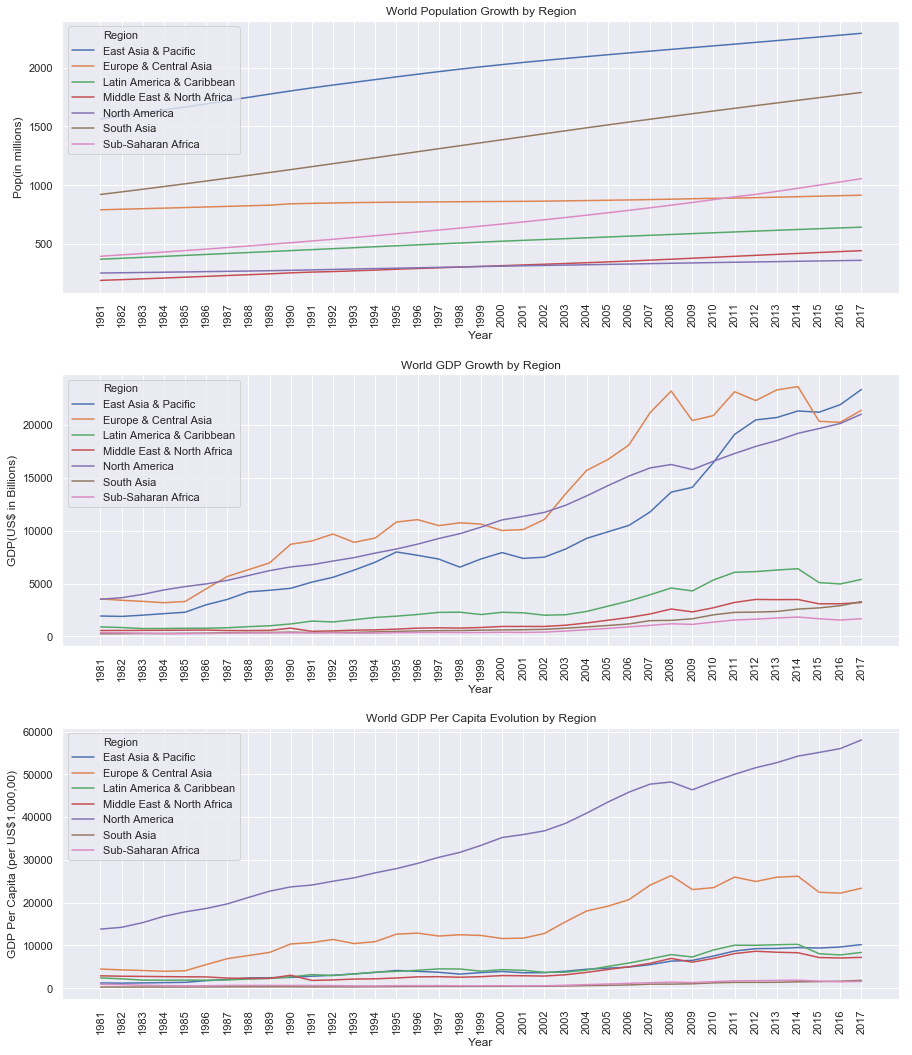

In [4]:
fig,ax = plt.subplots(nrows=3, figsize=(15,18))
titles = ['World Population Growth by Region', 'World GDP Growth by Region', 'World GDP Per Capita Evolution by Region']
for i in range(3):
    plt.sca(ax[i])
    plt.title(titles[i])
    plt.xticks(rotation=90)
    plt.subplots_adjust(hspace=0.3)

sns.lineplot(x='Year', y='Pop(in millions)', hue='Region', data=historical_pop_by_region, ax=ax[0])
sns.lineplot(x='Year', y='GDP(US$ in Billions)', hue='Region', data=historical_gdp_by_region, ax=ax[1])
sns.lineplot(x='Year', y='GDP Per Capita (per US$1.000,00)', hue='Region', data=historical_gdp_per_capita_by_region, ax=ax[2])

## Analyzing Extreme Poverty Distribution around the Globe

In [7]:
def createWBDataFrame(path):
    df = pd.read_csv(path, header=2)
    df = pd.merge(df, country_metadata, how='left', on=['Country Code'])
    return df.drop(['Indicator Name', 'Unnamed: 63'], axis=1)

def tideWBDataFrame(df):
    df = pd.melt(df, id_vars=['Country Name', 'Country Code', 'Region', 'Indicator Code'], var_name='Year', value_name='observation')
    df = pd.pivot_table(df, columns=['Indicator Code'], index=['Country Name', 'Country Code', 'Region', 'Year'], values='observation', aggfunc=np.mean)
    return df.reset_index()

def keepMetrics(df, metrics):
    standard_columns = ['Country Name', 'Country Code', 'Region', 'Year']
    return df.loc[:, standard_columns + metrics]

In [8]:
extreme_poverty_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
extreme_poverty_by_country = tideWBDataFrame(extreme_poverty_by_country)

# Limiting data for the last 30 years
extreme_poverty_by_country = extreme_poverty_by_country[extreme_poverty_by_country['Year'] > '1980']
extreme_poverty_by_country = keepMetrics(extreme_poverty_by_country, ['SI.POV.DDAY','SP.POP.TOTL'])

# Renaming observation columns
extreme_poverty_by_country.rename(columns={'SI.POV.DDAY': 'Extreme Poverty(% pop)','SP.POP.TOTL': 'Total Pop.'}, inplace=True)

### 1.0 - Extreme Poverty Distribution

In [9]:
# Manipulating data to bring a better understanding of the situation.
extreme_poverty_by_country['last_obs_year'] = np.nan
extreme_poverty_by_country['last_obs_year'] = extreme_poverty_by_country[extreme_poverty_by_country['Extreme Poverty(% pop)'].notnull()]['Year']
extreme_poverty_by_country.sort_values(['Country Code', 'Year'], inplace=True)

aux = pd.DataFrame(columns=extreme_poverty_by_country.columns)
for code in extreme_poverty_by_country['Country Code'].unique():
    aux = pd.concat([aux, extreme_poverty_by_country[extreme_poverty_by_country['Country Code'] == code].fillna(method='ffill')])
extreme_poverty_by_country = aux

extreme_poverty_by_country['Total Pop. in Extreme Poverty'] = extreme_poverty_by_country['Total Pop.']*extreme_poverty_by_country['Extreme Poverty(% pop)']/100
extreme_poverty_by_country['text'] = ["{one}<br>Extreme Poverty: {two} % <br>Extreme Poverty: {three} millions<br>Last obtained: {four}".format(one=row['Country Name'], two=row['Extreme Poverty(% pop)'], three=np.round(row['Total Pop. in Extreme Poverty']/10**6, 3), four=row['last_obs_year']) for index, row in extreme_poverty_by_country.iterrows()]     

### First Visualization

In [11]:
data_slider = []
for year in extreme_poverty_by_country['Year'].unique():
    extreme_poverty_year = extreme_poverty_by_country[extreme_poverty_by_country['Year'] == year]
    
    data = go.Choropleth(
                locationmode='ISO-3',
                locations=extreme_poverty_year['Country Code'],
                text=extreme_poverty_year['text'],
                z=extreme_poverty_year['Extreme Poverty(% pop)'],
                colorbar={'title':'Extreme Poverty (% of Population)','ticksuffix': '%'} 
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of Extreme Poverty (From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                steps = steps,
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1}
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

### Second Visualization

In [9]:
extreme_poverty_by_region = extreme_poverty_by_country.loc[:, ['Region', 'Year', 'Total Pop. in Extreme Poverty', 'Total Pop.']]
extreme_poverty_by_region.dropna(inplace=True)

extreme_poverty_by_region = extreme_poverty_by_region.groupby(['Region', 'Year'], as_index=False).agg({'Total Pop. in Extreme Poverty': 'sum', 'Total Pop.': 'sum'})
extreme_poverty_by_region['Mean Pop. in Extreme Poverty'] = np.round(100*extreme_poverty_by_region['Total Pop. in Extreme Poverty']/extreme_poverty_by_region['Total Pop.'], 2)

extreme_poverty_by_region = extreme_poverty_by_region[extreme_poverty_by_region['Year'] >= '1990']
extreme_poverty_by_region.sort_values(by=['Year', 'Region'], inplace=True)

In [35]:
layout = go.Layout(
    title='Population Living in Extreme Poverty by Region (%)',
    xaxis = go.layout.XAxis(
        tickmode='array',
        tickvals=np.arange(1990, 2018, step=1),
        tickangle=45,
        title='Years'
    ),
    yaxis = go.layout.YAxis(
        title='Pop. in Extreme Poverty(%)',
        autorange=True
    )
)

fig = go.Figure(
    layout=layout
)
        
for region in extreme_poverty_by_region['Region'].unique():
    ext_pov_region = extreme_poverty_by_region[extreme_poverty_by_region['Region'] == region]
    fig.add_scatter(x=ext_pov_region['Year'], y=ext_pov_region['Mean Pop. in Extreme Poverty'], name=region, mode='lines')
    
iplot(fig, filename='extreme poverty by region')

## Analyzing Deeper Socioeconomical, Healthy and Environmental Factors

#### Sub-Saharan Africa and South Asia are clearly the regions that need most assistance when it comes to eradicating poverty. 
#### Hence they along with Latin America will be the ones we look deeper to understand the driving factors that inhibit development on these countries.
#### In this section, we look at environmental, health, social and economical factors that might keep a nation from thriving economically. 

In [118]:
health_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Health\\API_8_DS2_en_csv_v2_10576655.csv')
health_by_country = tideWBDataFrame(health_by_country)
health_by_country = keepMetrics(health_by_country, ['SH.DYN.MORT', 'SH.DYN.AIDS.ZS', 'SH.TBS.INCD', 'SH.DTH.COMM.ZS', 'SN.ITK.DEFC.ZS', 'SP.DYN.TFRT.IN', 'SH.XPD.CHEX.GD.ZS'])
health_by_country.rename(columns={'SH.DYN.MORT': 'Mortality Rate Under 5(per 1.000 births)', 'SH.DYN.AIDS.ZS':'HIV - 15 to 49 (%)', 'SH.TBS.INCD': 'Inc. Tuberculosis(per 100.000)', 'SH.DTH.COMM.ZS': 'Death by Infectious Disease(5 of total)', 'SN.ITK.DEFC.ZS':'Undernourishment(% pop)', 'SP.DYN.TFRT.IN': 'Total Births per Women', 'SH.XPD.CHEX.GD.ZS': 'Expenditure on Health(% of GDP)'}, inplace=True)
health_by_country = health_by_country[health_by_country['Year'] >= '1990']

underage_labour_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Labour\\API_10_DS2_en_csv_v2_10597117.csv')
underage_labour_by_country = tideWBDataFrame(underage_labour_by_country)
underage_labour_by_country = keepMetrics(underage_labour_by_country, ['SL.TLF.0714.ZS', 'SL.TLF.0714.WK.ZS', 'SL.TLF.0714.WK.TM', 'SL.UEM.NEET.ZS'])
underage_labour_by_country.rename(columns={'SL.TLF.0714.ZS': 'Children in employment 7-14 (% of children)', 'SL.TLF.0714.WK.ZS': 'Children in employment(Work only) - 7 to 14(% of chd in emp.)', 'SL.TLF.0714.WK.TM': 'Avg. Working Hours of work only children', 'SL.UEM.NEET.ZS': 'Not studying, not working (% of youth)'}, inplace=True)
underage_labour_by_country = underage_labour_by_country[underage_labour_by_country['Year'] >= '1990']

education_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Education\\API_4_DS2_en_csv_v2_10577018.csv')
education_by_country = tideWBDataFrame(education_by_country)
education_by_country = keepMetrics(education_by_country, ['SE.PRM.CMPT.ZS', 'SE.PRM.UNER.ZS', 'SE.PRM.ENRL.TC.ZS', 'SE.ADT.1524.LT.ZS', 'SE.XPD.TOTL.GD.ZS'])
education_by_country.rename(columns={'SE.PRM.CMPT.ZS': 'Primary Completion Rate (% of relevant age group)', 'SE.PRM.UNER.ZS': 'Children out of School(% primary school)',  'SE.PRM.ENRL.TC.ZS': 'Pupil Teacher ratio', 'SE.ADT.1524.LT.ZS': 'Youth Literacy Rate 15-24 (% pop)', 'SE.XPD.TOTL.GD.ZS': 'Expenditure on Education (% of GDP)'}, inplace=True)
education_by_country = education_by_country[education_by_country['Year'] >= '1990']

economics_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Economics\\API_3_DS2_en_csv_v2_10577958.csv')
economics_by_country = tideWBDataFrame(economics_by_country)
economics_by_country = keepMetrics(economics_by_country, ['NY.GDP.PCAP.CD', 'NY.GDP.MKTP.KD.ZG', 'FP.CPI.TOTL.ZG', 'DT.ODA.ODAT.PC.ZS'])
economics_by_country.rename(columns={'NY.GDP.PCAP.CD': 'GDP per Capita(US$)', 'NY.GDP.MKTP.KD.ZG': 'GDP Growth(%)', 'FP.CPI.TOTL.ZG': 'Inflation Rate(%)', 'DT.ODA.ODAT.PC.ZS': 'ODA per capita(US$)'}, inplace=True)
economics_by_country = economics_by_country[economics_by_country['Year'] >= '1990']
economics_by_country['text'] = ["{one}<br>GDP Growth: {two}% <br>GDP per capita: US${three} <br>Inflation Rate: {four}% <br>ODA per capita: US${five}".format(one=row['Country Name'], two=np.round(row['GDP Growth(%)'],2), three=np.round(row['GDP per Capita(US$)'],2), four=np.round(row['Inflation Rate(%)'],2), five=np.round(row['ODA per capita(US$)'],2)) for index, row in economics_by_country.iterrows()] 

environment_by_country = createWBDataFrame('data\\SOCIAL_ENV_ECON_FACTORS_BY_COUNTRY\\Environment\\API_19_DS2_en_csv_v2_10515758.csv')
environment_by_country = tideWBDataFrame(environment_by_country)
environment_by_country = keepMetrics(environment_by_country, ['AG.LND.PRCP.MM','EN.CLC.MDAT.ZS','AG.LND.ARBL.ZS','AG.LND.IRIG.AG.ZS','NV.AGR.TOTL.ZS','AG.YLD.CREL.KG', 'EG.ELC.ACCS.ZS'])
environment_by_country.rename(columns={'AG.LND.PRCP.MM': 'Avg precipitation(mm)','EN.CLC.MDAT.ZS': '% Pop affected by extreme conditions(Droughts, Flood, high temps)','AG.LND.ARBL.ZS': '% Arable Land','AG.LND.IRIG.AG.ZS': '% Agric. Irrigated Land','NV.AGR.TOTL.ZS': 'Agric., Florestry and Fishing(% of GDP)','AG.YLD.CREL.KG': 'Cereal Yield(Kg/hectare)','EG.ELC.ACCS.ZS': 'Access Electricity(% pop)'}, inplace=True)
environment_by_country = environment_by_country[environment_by_country['Year'] >= '1990']

### GDP Growth by Population below Extreme Poverty Patterns

#### Hypothesis: It should exist a correlation between GDP Growth and Population living below the line of extreme poverty (1,90 dollars per day). The more the GDP of a country or region grows the less people will be living below standard extreme poverty patterns.

In [106]:
econ_per_capita = economics_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'GDP per Capita(US$)', 'ODA per capita(US$)']]
econ_per_capita_by_region = econ_per_capita.groupby(['Year', 'Region'], as_index=False).agg({'GDP per Capita(US$)': np.mean, 'ODA per capita(US$)':np.mean})
econ_per_capita_by_region['GDP per Capita(US$)'] = np.round(econ_per_capita_by_region['GDP per Capita(US$)'], 2)
econ_per_capita_by_region['ODA per capita(US$)'] = np.round(econ_per_capita_by_region['ODA per capita(US$)'], 2)

grouped_econ_ext_poverty = pd.merge(extreme_poverty_by_region, econ_per_capita_by_region, on=['Year', 'Region'])

In [109]:
fig = go.Figure()
fig = tools.make_subplots(
        rows=4, 
        cols=2, 
        subplot_titles=[reg for reg in grouped_econ_ext_poverty['Region'].unique()],
        vertical_spacing=0.10,
        horizontal_spacing=0.20)

perc_pop_ext_poverty = []
gdp_per_capita = []
for region in grouped_econ_ext_poverty['Region'].unique():
    g_econ_ext_pov_region = grouped_econ_ext_poverty[grouped_econ_ext_poverty['Region'] == region]
    gdp_per_capita.append(
        go.Scatter(
            x=g_econ_ext_pov_region['Year'], 
            y=g_econ_ext_pov_region['GDP per Capita(US$)'], 
            name='GDP per Capita(US$)', 
            mode='lines',
            showlegend=False,
            marker=go.scatter.Marker(color='Orange')
        )
    )
    
    perc_pop_ext_poverty.append(
        go.Scatter(
            x=g_econ_ext_pov_region['Year'], 
            y=g_econ_ext_pov_region['Mean Pop. in Extreme Poverty'], 
            name='Extreme Poverty Pop.(%)', 
            mode='lines',
            showlegend=False,
            marker=go.scatter.Marker(color='Blue')
        )
    )

fig['layout'].update(
    go.Layout(
        height=1000,
        width=1000,
        title='GDP per Capita by Population Living in Extreme Poverty',
        yaxis1=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis2=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis3=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis4=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis5=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis6=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis7=go.layout.YAxis(title='Pop. in Extreme Poverty(%)', autorange=True),
        yaxis8=go.layout.YAxis(title='GDP per Capita', overlaying='y1', anchor='x1', side='right', autorange=True, showgrid= False),
        yaxis9=go.layout.YAxis(title='GDP per Capita', overlaying='y2', anchor='x2', side='right', autorange=True, showgrid= False),
        yaxis10=go.layout.YAxis(title='GDP per Capita', overlaying='y3', anchor='x3', side='right', autorange=True, showgrid= False),
        yaxis11=go.layout.YAxis(title='GDP per Capita', overlaying='y4', anchor='x4', side='right', autorange=True, showgrid= False),
        yaxis12=go.layout.YAxis(title='GDP per Capita', overlaying='y5', anchor='x5', side='right', autorange=True, showgrid= False),
        yaxis13=go.layout.YAxis(title='GDP per Capita', overlaying='y6', anchor='x6', side='right', autorange=True, showgrid= False),
        yaxis14=go.layout.YAxis(title='GDP per Capita', overlaying='y7', anchor='x7', side='right', autorange=True, showgrid= False)
    )
)

for i in range(7):
    col = i%2 + 1
    row = i//2 + 1
    if i == 0:
        perc_pop_ext_poverty[i]['showlegend'] = True
        gdp_per_capita[i]['showlegend'] = True
        
    fig.append_trace(perc_pop_ext_poverty[i], row, col)
    fig.append_trace(gdp_per_capita[i], row, col)

for i in range(7):
    fig['data'][2*i+1].update(yaxis='y{one}'.format(one=8+i))

iplot(fig, filename='Small Multiples: GDP per capita and Extreme Poverty Pop.(%)')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



### 1.3 - Principal Problems faced by different regions

##### How is the expenditure of Africa's GDP distributed? How much goes to Education? How much goes to Medical Care?

##### How dependent is Africa on their agricultural production? What % of the GDP does it represent?

##### Which countries have lower literacy rate and higher disease problems? What about children education? Are they at school or working?

##### How is the ODA distributed among the countries? Are the countries with highest ODA per capita the ones that need most assistance?

##### Are the fundamental living assets available to most people: electricity, fresh water, internet, etc? 

### GDP Health and Education Expenditures Compared to GDP Growth (2000-2017)

In [122]:
ed_expenditure = education_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Education (% of GDP)']]
health_expenditure = health_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'Expenditure on Health(% of GDP)']]
econ_growth = economics_by_country.loc[:, ['Year', 'Region', 'Country Code', 'Country Name', 'GDP Growth(%)']]

grouped_ed_health_exp = pd.merge(ed_expenditure, health_expenditure, on=['Year', 'Region', 'Country Code', 'Country Name'])
grouped_ed_health_econ_exp = pd.merge(grouped_ed_health_exp, econ_growth, on=['Year', 'Region', 'Country Code', 'Country Name'])

grouped_ed_health_econ_exp = grouped_ed_health_econ_exp.groupby(['Year', 'Region'], as_index=False).agg({'Expenditure on Education (% of GDP)':'mean', 'Expenditure on Health(% of GDP)': 'mean', 'GDP Growth(%)': 'mean'})
grouped_ed_health_econ_exp = grouped_ed_health_econ_exp[grouped_ed_health_econ_exp['Year']>'1999']

In [123]:
fig = go.Figure()
fig = tools.make_subplots(
        rows=4, 
        cols=2, 
        subplot_titles=[reg for reg in grouped_ed_health_econ_exp['Region'].unique()],
        vertical_spacing=0.10)

exp_education = []
exp_health = []
gdp_growth = []
for reg in grouped_ed_health_econ_exp['Region'].unique():
    reg_grouped_ed_health_econ_exp = grouped_ed_health_econ_exp[grouped_ed_health_econ_exp['Region'] == reg]

    reg_exp_education = go.Bar(
            x=reg_grouped_ed_health_econ_exp['Year'], 
            y=reg_grouped_ed_health_econ_exp['Expenditure on Education (% of GDP)'], 
            name='Education (% of GDP)',
            showlegend=False,
            marker=go.bar.Marker(
                color='Blue'))

    reg_exp_health = go.Bar(
            x=reg_grouped_ed_health_econ_exp['Year'], 
            y=reg_grouped_ed_health_econ_exp['Expenditure on Health(% of GDP)'], 
            name='Health (% of GDP)',
            showlegend=False,
            marker=go.bar.Marker(
                color='Orange'))

    reg_gdp_growth = go.Scatter(
            x=reg_grouped_ed_health_econ_exp['Year'], 
            y=reg_grouped_ed_health_econ_exp['GDP Growth(%)'], 
            name='GDP Growth(%)', 
            showlegend=False,
            mode='lines',
            marker=go.scatter.Marker(
                color='Green'))

    exp_education.append(reg_exp_education)
    exp_health.append(reg_exp_health)
    gdp_growth.append(reg_gdp_growth)

for i in range(8):
    col = i%2 + 1
    row = i//2 + 1
    
    exp_education[0]['showlegend'] = True
    exp_health[0]['showlegend'] = True
    gdp_growth[0]['showlegend'] = True
    if i < 7:
        fig.append_trace(exp_education[i], row, col)
        fig.append_trace(exp_health[i], row, col)
        fig.append_trace(gdp_growth[i], row, col)

fig['layout'].update({'title': 'Health and Education Expenditures compared to GDP Growth', 
                      'height': 1000, 
                      'width': 1000})        
py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [230]:
health_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6073 entries, 30 to 12552
Data columns (total 11 columns):
Country Name                                6073 non-null object
Country Code                                6073 non-null object
Region                                      6073 non-null object
Year                                        6073 non-null object
Mortality Rate Under 5(per 1.000 births)    5404 non-null float64
HIV - 15 to 49 (%)                          3808 non-null float64
Inc. Tuberculosis(per 100.000)              3719 non-null float64
Death by Infectious Disease(5 of total)     732 non-null float64
Undernourishment(% pop)                     2781 non-null float64
Total Births per Women                      5584 non-null float64
Expenditure on Health(% of GDP)             3170 non-null float64
dtypes: float64(7), object(4)
memory usage: 569.3+ KB


### Current Situation of Poorest Regions - 2017 (Latin America, Sub-Saarian Africa and South Asia)

In [241]:
id_region = dict({'South Asia': 0.1, 'Sub-Saharan Africa': 0.5, 'Latin America & Caribbean': 1.0})

education_by_country_2016 = education_by_country[(education_by_country['Year'] == '2016') & (education_by_country['Region'].isin(['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa']))]
#education_by_country_2016.dropna(subset=['Primary Completion Rate (% of relevant age group)', 'Children out of School(% primary school)', 'Pupil Teacher ratio'], inplace=True)

health_by_country_2016 = health_by_country[(health_by_country['Year'] == '2016') & (health_by_country['Region'].isin(['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa']))]
#health_by_country_2016.dropna(subset=['Mortality Rate Under 5(per 1.000 births)', 'HIV - 15 to 49 (%)', 'Inc. Tuberculosis(per 100.000)', 'Undernourishment(% pop)'], inplace=True)

education_by_country_2016['id_region'] = [id_region[region] for region in education_by_country_2016['Region']]
health_by_country_2016['id_region'] = [id_region[region] for region in health_by_country_2016['Region']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### Educational Analysis

In [243]:
data = [
    go.Parcoords(
        ids=education_by_country_2016['Country Name'],
        line=dict(color=education_by_country_2016['id_region'],
                 colorscale='Viridis'),
        
        dimensions = list([
            dict(range=[0,150],
                 label='Primary Completion Rate(%)', 
                 values=np.round(education_by_country_2016['Primary Completion Rate (% of relevant age group)'], 2)),
            
            dict(range=[0,100],
                 label='Children out of School(%)', 
                 values=np.round(education_by_country_2016['Children out of School(% primary school)'], 2)),
            
            dict(range=[0,150],
                 label='Pupil Teacher Ratio', 
                 values=np.round(education_by_country_2016['Pupil Teacher ratio']))
        ])
    )
]

layout = go.Layout(
    height=500,
    width=1000,
    paper_bgcolor='#ffffff'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'parcoords-education')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



#### Health Analysis

In [245]:
health_by_country_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 56 to 12551
Data columns (total 12 columns):
Country Name                                98 non-null object
Country Code                                98 non-null object
Region                                      98 non-null object
Year                                        98 non-null object
Mortality Rate Under 5(per 1.000 births)    89 non-null float64
HIV - 15 to 49 (%)                          76 non-null float64
Inc. Tuberculosis(per 100.000)              96 non-null float64
Death by Infectious Disease(5 of total)     87 non-null float64
Undernourishment(% pop)                     75 non-null float64
Total Births per Women                      92 non-null float64
Expenditure on Health(% of GDP)             87 non-null float64
id_region                                   98 non-null float64
dtypes: float64(8), object(4)
memory usage: 10.0+ KB


In [247]:
data = [
    go.Parcoords(
        ids=health_by_country_2016['Country Name'],
        line=dict(color=health_by_country_2016['id_region'],
                 colorscale='Viridis'),
        
        dimensions = list([
            dict(range=[0,300],
                 label='Mortality Rate Under 5(per 1.000 births)', 
                 values=health_by_country_2016['Mortality Rate Under 5(per 1.000 births)']),
            
            dict(range=[0,100],
                 label='Undernourishment(%)', 
                 values=np.round(health_by_country_2016['Undernourishment(% pop)'], 2)),
            
            dict(range=[0,100],
                 label='HIV - 15 to 49 (%)', 
                 values=np.round(health_by_country_2016['HIV - 15 to 49 (%)'], 2)),
            
            dict(range=[0,1000],
                 label='Inc. Tuberculosis(per 100.000)', 
                 values=health_by_country_2016['Inc. Tuberculosis(per 100.000)']),
        ])
    )
]

layout = go.Layout(
    height=500,
    width=1000,
    paper_bgcolor='#ffffff'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'parcoords-education')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [106]:
data_slider = []
for year in economics_by_country_africa['Year'].unique():
    economics_by_country_africa_year = economics_by_country_africa[economics_by_country_africa['Year'] == year]
    
    data = go.Choropleth(
            locationmode='ISO-3',
            locations=economics_by_country_africa_year['Country Code'],
            text=economics_by_country_africa_year['text'],
            z=np.round(economics_by_country_africa_year['GDP Growth(%)'],2),
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP Growth(%)', 'ticksuffix': '%'},
        )
    data_slider.append(data)

steps = []
for i in range(len(data_slider)):
    correct_value = [False] * len(data_slider)
    correct_value[i] = True
    
    step = go.layout.slider.Step(
        method='restyle',
        args=['visible', correct_value],
        label="{}".format(1981+i)
    )
    steps.append(step)

layout = go.Layout(
            title = go.layout.Title(
                text = 'Evolution of GDP Growth(From 1981 to 2017)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            ),
            sliders = [go.layout.Slider(
                active = 0,
                currentvalue = {"prefix": "Year: "},
                pad = {"t": 1},
                steps = steps
            )]
        )
fig = go.Figure(data=data_slider, layout=layout)
iplot(fig)

In [18]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3716 entries, 12 to 7050
Data columns (total 8 columns):
Country Name                                                     3716 non-null object
Country Code                                                     3716 non-null object
Region                                                           3716 non-null object
Year                                                             3716 non-null object
Children in employment 7-14 (% of children)                      267 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    268 non-null float64
Avg. Working Hours of work only children                         124 non-null float64
Not studying, not working (% of youth)                           1192 non-null float64
dtypes: float64(4), object(4)
memory usage: 261.3+ KB


In [ ]:
economics_by_country_south_asia = economics_by_country[economics_by_country['Region'] == 'South Asia']

In [ ]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=critical_regions_gdp_pop_by_country['Country Code'],
            text=critical_regions_gdp_pop_by_country['Country Name'],
            z=critical_regions_gdp_pop_by_country['GDP Per Capita (per US$1.000,00)'],
            colorscale = [
                [0, "rgb(129, 24, 36)"],
                [0.2, "rgb(153, 64, 74)"],
                [0.4, "rgb(177, 105, 113)"],
                [0.6, "rgb(202, 146, 152)"],
                [0.8, "rgb(226, 187, 191)"],
                [1, "rgb(251, 228, 230)"]
            ],
            colorbar = {'title':'GDP per capita (in US$1.000,00)'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2017 South Asia GDP per capita'
            ),
            geo = go.layout.Geo(
                scope='asia',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [125]:
underage_labour_by_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7051 entries, 0 to 7050
Data columns (total 8 columns):
Country Name                                                     7051 non-null object
Country Code                                                     7051 non-null object
Region                                                           7051 non-null object
Year                                                             7051 non-null object
Children in employment 7-14 (% of children)                      281 non-null float64
Children in employment(Work only) - 7 to 14(% of chd in emp.)    282 non-null float64
Avg. Working Hours of work only children                         126 non-null float64
SL.UEM.NEET.ZS                                                   1235 non-null float64
dtypes: float64(4), object(4)
memory usage: 440.8+ KB


In [ ]:
## Find correlation about the metrics

In [48]:
data = [go.Choropleth(
            locationmode='ISO-3',
            locations=social_metrics_by_country_2016['Country Code'],
            text=social_metrics_by_country_2016['Country Name'],
            z=social_metrics_by_country_2016['Access Electricity(% pop)'],
            colorbar = {'title':'Access to Electricity',
                        'ticksuffix': '%'} 
        )]

layout = go.Layout(
            title = go.layout.Title(
                text = '2016 - Access to Electricity (% of pop)'
            ),
            geo = go.layout.Geo(
                scope='world',
                showframe = False,
                showcoastlines = False,
                projection = go.layout.geo.Projection(
                    type = 'equirectangular'
                )
            )
        )
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
pal_1 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7', '#d95f0e', '#dd1c77']
pal_2 = ['#3182bd', '#e6550d', '#31a354', '#de2d26', '#8856a7']
# Line chart grouping extreme poverty data by region

# This chart only takes into account the countries that have provided at least one data regarding Extreme Poverty in the timeframe presented(1981-2017).
# The data for Extreme Poverty considered by the chart is the last data provided by the country.
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (1990 - 2018)')
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region, palette=pal_1)

# Show another line chart to focus on the last years for East Asia, Latin America, North America, Middle East and Europe
plt.figure(figsize=(6, 5))
plt.xticks(rotation=45)
plt.title('Extreme Poverty(%) by Region (2010 - 2018)')
extreme_poverty_by_region_sub = extreme_poverty_by_region[(~extreme_poverty_by_region['Region'].isin(['South Asia', 'Sub-Saharan Africa'])) & (extreme_poverty_by_region['Year']>='2010')]
sns.lineplot(x='Year', y='Mean Pop. in Extreme Poverty', hue='Region', data=extreme_poverty_by_region_sub, palette=pal_2)